In [2]:
!git clone --recursive https://github.com/Rithik-Alias/Analysis-on-covid-data.git
%cd /content/Analysis-on-covid-data

Cloning into 'Analysis-on-covid-data'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
/content/Analysis-on-covid-data


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
covid = pd.read_csv('covid19_italy_region.csv',parse_dates=['Date'],index_col='Date')
covid.head()

,SNo,Country,RegionCode,RegionName,Latitude,Longitude,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
Date,,,,,,,,,,,,,,,,
2020-02-24 18:00:00,0,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,NaN
2020-02-24 18:00:00,1,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,NaN
2020-02-24 18:00:00,2,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,NaN
2020-02-24 18:00:00,3,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,NaN
2020-02-24 18:00:00,4,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,18,0,0,18,NaN


In [ ]:
time_series = covid[['NewPositiveCases']]
time_series

,NewPositiveCases
Date,
2020-02-24 18:00:00,0
2020-02-24 18:00:00,0
2020-02-24 18:00:00,0
2020-02-24 18:00:00,0
2020-02-24 18:00:00,18
...,...
2020-12-06 17:00:00,1022
2020-12-06 17:00:00,753
2020-12-06 17:00:00,234


In [ ]:
time_series = time_series.groupby('Date').mean()


In [ ]:
time_series.head()

,NewPositiveCases
Date,
2020-02-24 18:00:00,10.523810
2020-02-25 18:00:00,4.428571
2020-02-26 18:00:00,3.714286
2020-02-27 18:00:00,11.904762
2020-02-28 18:00:00,11.333333


In [ ]:
np.random.seed(7)

In [ ]:
dataset = time_series.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

192 95


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
190/190 - 2s - loss: 0.0020
Epoch 2/100
190/190 - 0s - loss: 0.0017
Epoch 3/100
190/190 - 0s - loss: 0.0015
Epoch 4/100
190/190 - 0s - loss: 0.0013
Epoch 5/100
190/190 - 0s - loss: 0.0011
Epoch 6/100
190/190 - 0s - loss: 9.0739e-04
Epoch 7/100
190/190 - 0s - loss: 6.5413e-04
Epoch 8/100
190/190 - 0s - loss: 4.7431e-04
Epoch 9/100
190/190 - 0s - loss: 3.1774e-04
Epoch 10/100
190/190 - 0s - loss: 1.8476e-04
Epoch 11/100
190/190 - 0s - loss: 1.2446e-04
Epoch 12/100
190/190 - 0s - loss: 9.9728e-05
Epoch 13/100
190/190 - 0s - loss: 8.4600e-05
Epoch 14/100
190/190 - 0s - loss: 7.9554e-05
Epoch 15/100
190/190 - 0s - loss: 8.2311e-05
Epoch 16/100
190/190 - 0s - loss: 8.2791e-05
Epoch 17/100
190/190 - 0s - loss: 8.4451e-05
Epoch 18/100
190/190 - 0s - loss: 8.2919e-05
Epoch 19/100
190/190 - 0s - loss: 8.4352e-05
Epoch 20/100
190/190 - 0s - loss: 8.3567e-05
Epoch 21/100
190/190 - 0s - loss: 8.0220e-05
Epoch 22/100
190/190 - 0s - loss: 8.4887e-05
Epoch 23/100
190/190 - 0s - loss: 8.678

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 17.35 RMSE
Test Score: 174.92 RMSE


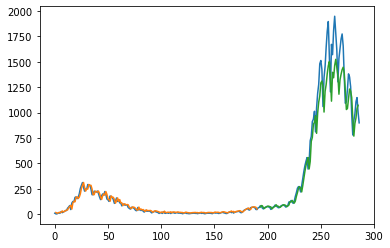

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()